In [276]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### 1. 데이터 로드

In [277]:
df = pd.read_csv('Train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [278]:
# dataset 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#### 2. 목표 및 모델 선정 과정
1) 저지방 제품과 일반 제품 중 경쟁력 있는 품목은 어떤 것인가
    - 판매상품(Item_Type)의 저지방 / 일반 제품 분류
    - 최대 소매가의 금액에 따라 판매 금액에 변동이 있는지
    - 제품의 가격이 저렴할수록 판매금액이 늘어나는지
2) 단순선형회귀모델을 사용
    - 저지방 제품의 최대 소매가와 제품 판매금액 확인
    - 일반 제품의 최대 소매가와 제품 판매금액 확인
    - 

#### 3. 문제1

- Item_Fat_Content 항목 분류

In [279]:
df.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [280]:
# Item_Fat_Content를 LF(low fat)과 REG(Regular)로 분류
df['LF'] = df.apply(lambda x: 'LF' if x.Item_Fat_Content == 'Low Fat' else 'REG', axis=1)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,LF
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,LF
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,REG
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,LF
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,REG
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,LF


- Low Fat 제품 최대판매가, 판매금액

In [281]:
df1 = df[df.LF == 'LF'][['Item_Type', 'Item_MRP', 'Item_Outlet_Sales']]
df1

,Item_Type,Item_MRP,Item_Outlet_Sales
0,Dairy,249.8092,3735.1380
2,Meat,141.6180,2097.2700
4,Household,53.8614,994.7052
7,Snack Foods,107.7622,4022.7636
10,Fruits and Vegetables,45.5402,1516.0266
...,...,...,...
8515,Baking Goods,157.5288,1571.2880
8516,Others,58.7588,858.8820
8518,Snack Foods,214.5218,2778.3834
8520,Health and Hygiene,85.1224,1193.1136


In [282]:
df1 = df1.groupby('Item_Type')[['Item_Outlet_Sales', 'Item_MRP']].mean()
df1

,Item_Outlet_Sales,Item_MRP
Item_Type,,
Baking Goods,1781.871029,121.286145
Breads,2260.105657,138.264948
Breakfast,2507.863738,166.630097
Canned,2231.123365,139.846247
Dairy,2172.820871,148.114798
Frozen Foods,2094.821929,138.064242
Fruits and Vegetables,2181.465002,136.449031
Hard Drinks,2154.073781,137.782089
Health and Hygiene,2018.337403,131.062467


In [283]:
df1.rename(columns={"Item_Outlet_Sales" : "LF_Sales", "Item_MRP" : "LF_MRP"}, inplace=True)
df1.head()

,LF_Sales,LF_MRP
Item_Type,,
Baking Goods,1781.871029,121.286145
Breads,2260.105657,138.264948
Breakfast,2507.863738,166.630097
Canned,2231.123365,139.846247
Dairy,2172.820871,148.114798


- Regular 제품 최대판매가, 판매금액

In [284]:
df2 = df[df.LF == 'REG'][['Item_Type', 'Item_MRP', 'Item_Outlet_Sales']]
df2

,Item_Type,Item_MRP,Item_Outlet_Sales
1,Soft Drinks,48.2692,443.4228
3,Fruits and Vegetables,182.0950,732.3800
5,Baking Goods,51.4008,556.6088
6,Snack Foods,57.6588,343.5528
8,Frozen Foods,96.9726,1076.5986
...,...,...,...
8513,Meat,99.9042,595.2252
8514,Canned,57.5904,468.7232
8517,Frozen Foods,178.8318,3608.6360
8519,Baking Goods,108.1570,549.2850


In [285]:
df2 = df2.groupby('Item_Type')[['Item_Outlet_Sales', 'Item_MRP']].mean()
df2

,Item_Outlet_Sales,Item_MRP
Item_Type,,
Baking Goods,2101.389518,130.800020
Breads,2147.711008,143.661891
Breakfast,1894.257265,128.142575
Canned,2219.638078,139.686583
Dairy,2308.588262,148.988689
Frozen Foods,2170.209006,138.934358
Fruits and Vegetables,2384.678092,151.815404
Hard Drinks,1942.182987,127.736053
Health and Hygiene,1907.175564,127.815185


In [286]:
df2.rename(columns={"Item_Outlet_Sales" : "REG_Sales", "Item_MRP" : "REG_MRP"}, inplace=True)
df2.head()

,REG_Sales,REG_MRP
Item_Type,,
Baking Goods,2101.389518,130.800020
Breads,2147.711008,143.661891
Breakfast,1894.257265,128.142575
Canned,2219.638078,139.686583
Dairy,2308.588262,148.988689


In [287]:
df = df.copy()

In [288]:
df = df1.join(df2)
df

,LF_Sales,LF_MRP,REG_Sales,REG_MRP
Item_Type,,,,
Baking Goods,1781.871029,121.286145,2101.389518,130.800020
Breads,2260.105657,138.264948,2147.711008,143.661891
Breakfast,2507.863738,166.630097,1894.257265,128.142575
Canned,2231.123365,139.846247,2219.638078,139.686583
Dairy,2172.820871,148.114798,2308.588262,148.988689
Frozen Foods,2094.821929,138.064242,2170.209006,138.934358
Fruits and Vegetables,2181.465002,136.449031,2384.678092,151.815404
Hard Drinks,2154.073781,137.782089,1942.182987,127.736053
Health and Hygiene,2018.337403,131.062467,1907.175564,127.815185


In [289]:
df = df.round(2)
df

,LF_Sales,LF_MRP,REG_Sales,REG_MRP
Item_Type,,,,
Baking Goods,1781.87,121.29,2101.39,130.80
Breads,2260.11,138.26,2147.71,143.66
Breakfast,2507.86,166.63,1894.26,128.14
Canned,2231.12,139.85,2219.64,139.69
Dairy,2172.82,148.11,2308.59,148.99
Frozen Foods,2094.82,138.06,2170.21,138.93
Fruits and Vegetables,2181.47,136.45,2384.68,151.82
Hard Drinks,2154.07,137.78,1942.18,127.74
Health and Hygiene,2018.34,131.06,1907.18,127.82


- 선형회귀모델

In [290]:
# Low Fat: LF_Sales vs. LF_MRP
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(df.LF_MRP.values.reshape(-1,1), df.LF_Sales)
lr.score(df.LF_MRP.values.reshape(-1,1), df.LF_Sales)

0.8153788629093068

In [291]:
# Regular: REG_Sales vs. REG_MRP
lr2 = LinearRegression()
lr2.fit(df.REG_MRP.values.reshape(-1,1), df.REG_Sales)
lr2.score(df.REG_MRP.values.reshape(-1,1), df.REG_Sales)

0.8311404486979366

- 훈련 및 테스트

In [274]:
# Low Fat
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.LF_MRP.values.reshape(-1,1), df.LF_Sales, test_size=0.1, random_state=2021
)

In [292]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [293]:
lr.coef_, lr.intercept_, lr._residues

(array([16.52925243]), -167.271597741395, 91061.53192802625)

In [294]:
# 테스트
from sklearn.metrics import r2_score, mean_squared_error
pred = lr.predict(X_test)
r2_score(y_test, pred)

-0.8115935208369083

In [295]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mse, rmse

(27156.38329922213, 164.7919394242999)

In [275]:
# Regular
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df.REG_MRP.values.reshape(-1,1), df.REG_Sales, test_size=0.1, random_state=2021
)

In [296]:
lr2 = LinearRegression()
lr2.fit(X_train2, y_train2)

LinearRegression()

In [297]:
lr2.coef_, lr2.intercept_, lr2._residues

(array([16.43116393]), -119.41310116472914, 105249.63274079756)

In [298]:
# 테스트
pred2 = lr2.predict(X_test2)
r2_score(y_test2, pred2)

0.9558043489096617

In [299]:
mse2 = mean_squared_error(y_test2, pred2)
rmse2 = np.sqrt(mse2)
mse2, rmse2

(2200.171520735164, 46.90598597977836)

- 시각화

In [353]:
# Low fat: 기울기와 절편 구하기
xs = np.array([115, 170])
ys = xs * lr.coef_ + lr.intercept_
ys

array([1733.59243171, 2642.70131537])

In [354]:
# Regular: 기울기와 절편 구하기
xs2 = np.array([115, 170])
ys2 = xs2 * lr2.coef_ + lr2.intercept_
ys2

array([1770.170751  , 2673.88476726])

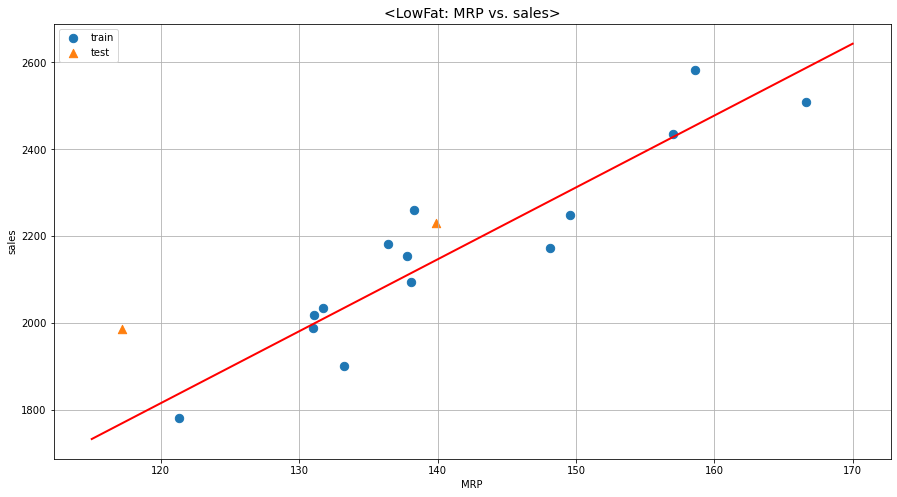

In [360]:
# Low Fat 
plt.figure(figsize=(15,8))
plt.scatter(X_train, y_train, label='train', s=70)
plt.scatter(X_test, y_test, marker='^', label='test', s=70)
plt.plot(xs, ys, 'r-', lw=2)
plt.grid()
plt.xlabel('MRP')
plt.ylabel('sales')
plt.title('<LowFat: MRP vs. sales>', fontsize=14)
plt.legend()
plt.show()

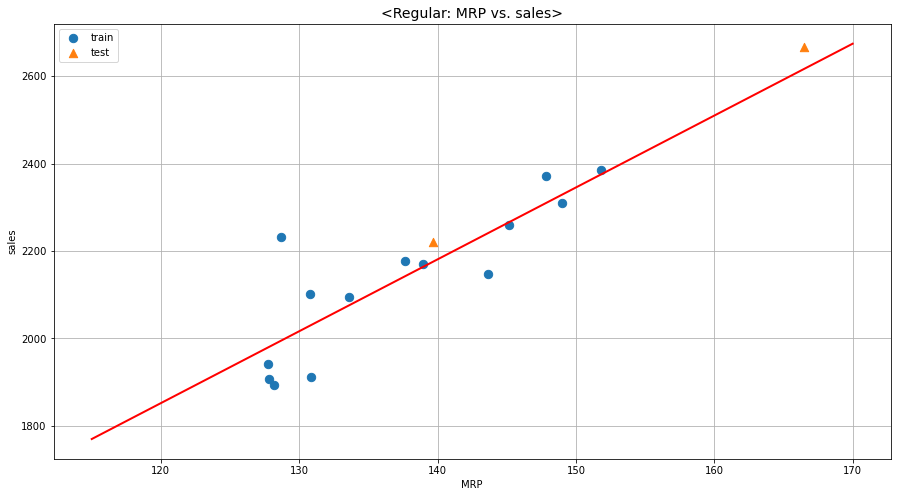

In [359]:
# Regular 
plt.figure(figsize=(15,8))
plt.scatter(X_train2, y_train2, label='train', s=70)
plt.scatter(X_test2, y_test2, marker='^', label='test', s=70)
plt.plot(xs2, ys2, 'r-', lw=2)
plt.grid()
plt.xlabel('MRP')
plt.ylabel('sales')
plt.title('<Regular: MRP vs. sales>', fontsize=14)
plt.legend()
plt.show()